# **Exploratory analysis of the data**

## Extra Preprocessing

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"

In [5]:
def trunc_length(ds, nb_hours):
#function that truncates the data to only consider the first nb_hours hours
    df = ds.loc[ds.index <=  nb_hours]
    df = df.loc[df.index > 0]
    return df

def create_batchs(ds):
    batchs = []
    ids = ds.stay_id.unique()
    for i in ids:
        batchs.append(ds.loc[ds['stay_id'] == i])
    return batchs

def remove_missing(df, var, threshold):
#remove from batch the entries where a too large proportion of the variables var are missing 
    res = df
    
    
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                    'percent_missing': percent_missing})
    for vital in var: 
        criterion = missing_value_df.loc[missing_value_df.column_name == vital].percent_missing >= threshold 
        if criterion:
            print('entry removed')
            print(missing_value_df.loc[missing_value_df.column_name == vital].percent_missing)
            df.drop([vital], axis = 1)
        else:
            res.append(batch[i])
    return res

def get_column_name(df):
    listn = [col for col in df.columns]
    return listn

def aggregation(batch, rate):
    'function that takes a batch of patients and returns the aggregated vitals with the correct aggregation rate'
    if rate == 1:
        return batch
    elif rate == 24:
        bch = []
        for df in batch:
            df['hour_slice'] = 0
            df['hour_slice'][range(25,49)] = 1
            df = df.groupby('hour_slice').mean()
            bch.append(df)
        return bch
    elif rate == 48:
        bch = []
        for df in batch:
            df['hour_slice'] = 0
            df = df.groupby('hour_slice').mean()
            bch.append(df)
        return bch



## Loading the data

In [6]:
nb_hours = 48
list_vit = ['HR', 'SpO2', 'ABPm', 'CPP', 'Temperature (C)']
list_vit_clean = ['Heart Rate (bpm)', 'Oxygen Saturation (%)', 'MAP (mmHg)', 'CPP (mmHg)', 'ICP (mmHg)']
df = pd.read_csv('data/preprocessed_mimic4_hour.csv', delimiter=',', index_col = 'hour_from_intime')
df = df.drop(columns = ['icu_intime'])


FileNotFoundError: [Errno 2] No such file or directory: 'data/preprocessed_mimic4_hour.csv'

In [ ]:
df_truncated = trunc_length(df, nb_hours)
df_final = df_truncated.pivot_table(index = ['stay_id', 'hour_from_intime'], columns = 'feature_name', values = 'round')
df_final = df_final.reset_index(level=['stay_id'])
bch = create_batchs(df_final)

for i in range(len(bch)):
    bch[i] = bch[i].reindex(range(0, nb_hours + 1), fill_value = None) 
    bch[i] = bch[i].drop(columns = 'stay_id')

df_final = pd.concat(bch)


In [ ]:
print(bch[55].sum()['HR'])

3104.42


In [ ]:
aggregated_24 = aggregation(bch, 24)
aggregated_48 = aggregation(bch, 48)

df_final_24 = pd.concat(aggregated_24)
df_final_48 = pd.concat(aggregated_48)

C:\Users\USER\AppData\Local\Temp\ipykernel_15432\194226770.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print(df_final)
vitals = get_column_name(df_final)
vitals.pop(0)

feature_name       stay_id  % Minute Volume  ABI Ankle BP L   ABI Ankle BP R  \
hour_from_intime                                                               
2                 30006565              NaN              NaN             NaN   
3                 30006565              NaN              NaN             NaN   
4                 30006565              NaN              NaN             NaN   
5                 30006565              NaN              NaN             NaN   
6                 30006565              NaN              NaN             NaN   
...                    ...              ...              ...             ...   
44                39985110              NaN              NaN             NaN   
45                39985110              NaN              NaN             NaN   
46                39985110              NaN              NaN             NaN   
47                39985110              NaN              NaN             NaN   
48                39985110              

In [ ]:
# for item in bch:
#     item.loc['total'] = item.sum()
test = pd.concat(bch)


test.replace(0, np.nan, inplace=True)
# print(test.loc['total'])

## Analysis of missing data

In [ ]:
# /!\ code à clean 
import plotly.graph_objects as go

miss_hr = []
miss_spO2 = []
miss_map = []
miss_icp = []
miss_cpp = []
for i in range(len(bch)):
        percent_missing = bch[i].isnull().sum() * 100 / len(bch[i])
        missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
        miss_hr.append(percent_missing['HR'])
        miss_spO2.append(percent_missing['SpO2'])
        miss_map.append(percent_missing['ABPm'])
        miss_cpp.append(percent_missing['CPP'])
        miss_icp.append(percent_missing['ICP'])

fig = go.Figure()
fig.update_layout(xaxis_title='Vitals missing percentage (N = 614)', yaxis_title = 'Percentage %')
fig.add_trace(go.Box(y=miss_hr, boxpoints='all', name = 'Heart rate'))
fig.add_trace(go.Box(y=miss_spO2, boxpoints='all', name = 'spO2'))
fig.add_trace(go.Box(y=miss_map, boxpoints='all', name = 'MAP'))
fig.add_trace(go.Box(y=miss_cpp, boxpoints='all', name = 'CPP'))
fig.add_trace(go.Box(y=miss_icp, boxpoints='all', name = 'ICP'))


fig.show()

In [ ]:
batchs = bch 
df = pd.concat(batchs)
missing_hist = []
for vit in list_vit:
    missing_hist.append([df.loc[i][vit].isnull().sum() for i in range(nb_hours)])

fig, axes = plt.subplots(2,3, figsize=(22, 10))
axe = axes.ravel()
axe[5].set_visible(False)
fig.suptitle('Histogram of missing vitals entries (N = 614)')
j = 0
for i in range(len(list_vit)):
    sns.histplot(ax = axe[i], x = range(nb_hours), weights =  missing_hist[i], bins = nb_hours)
    axe[i].set_title(list_vit_clean[i])
    axe[i].set_xlabel('Hour')



KeyError: 'Temperature (C)'

In [ ]:
#Removing missing data 
batchs = remove_missing(bch, ['heart_rate', 'oxygen_saturation', 'map'], threshold = 20)
print(len(batchs))

## Time-series plots - patterns

NameError: name 'batchs' is not defined

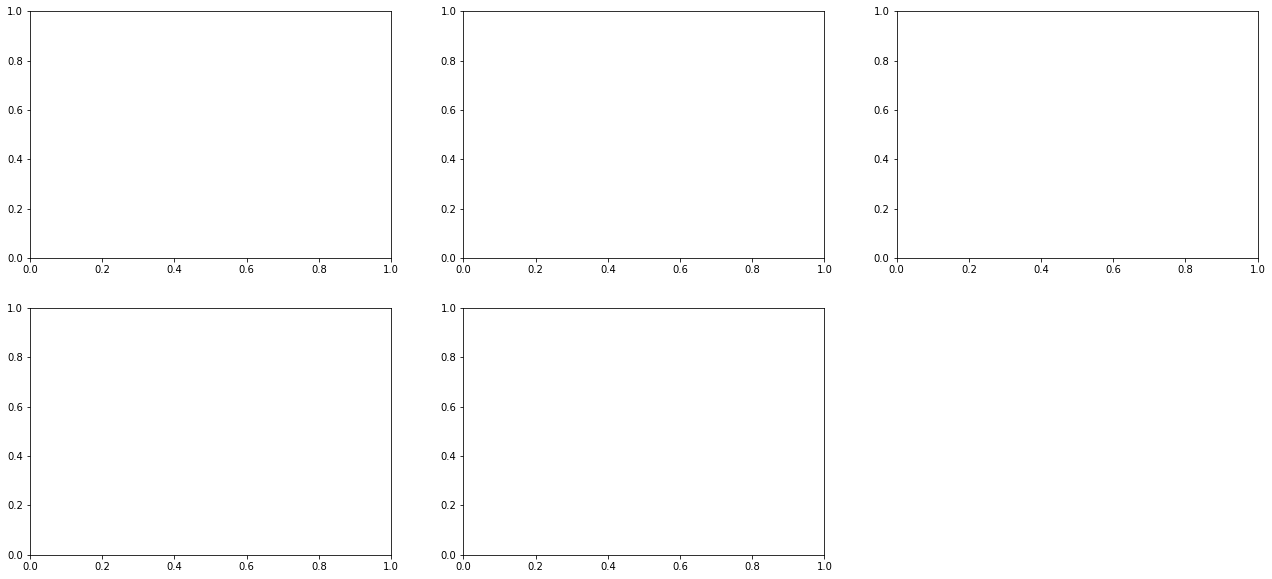

In [ ]:
#Simple plots of the variables
fig, axes = plt.subplots(2,3, figsize=(22, 10))
axe = axes.ravel()
axe[5].set_visible(False)
for i in range(len(list_vit)):
    color = iter(cm.rainbow(np.linspace(0, 1, len(batchs))))
    for patient in range(len(batchs)):
        c = next(color)
        batchs[patient][list_vit[i]].plot(ax = axe[i], xlabel = 'Hours', color = c, ylabel = list_vit_clean[i])
        axe[i].grid()


#faire une fonction threshold missing 
#faire une fonction pour chaque patient uqi peut être appliquée à chaque patient 

In [ ]:
import itertools

df = pd.concat(batchs)
agg_mean = (df).groupby(df.index).agg({'HR': np.mean, 'SpO2': np.mean, 'ABPm': np.mean, 'CPP': np.mean, 'ICP': np.mean})
agg_std = (df).groupby(df.index).agg({'HR': np.mean, 'SpO2': np.mean, 'ABPm': np.mean, 'CPP': np.mean, 'ICP': np.mean})
color = color = iter(cm.rainbow(np.linspace(0, 1, len(list_vit))))

fig, ax = plt.subplots(figsize=(9, 9))
fig.suptitle('Vitals analysis (N = 614)')
for i in range(len(list_vit)):
    c = next(color)
    ax.plot(range(nb_hours + 1), agg_mean[list_vit[i]], alpha=1, color=c, label=list_vit_clean[i], linewidth = 3.0)
    ax.fill_between(range(nb_hours + 1), agg_mean[list_vit[i]] - agg_std[list_vit[i]], agg_mean[list_vit[i]] + agg_std[list_vit[i]], color=c  , alpha=0.2)
    plt.grid()

ax.legend(loc='best')
ax.set_xlabel("Hours")

## Vitals univariate analysis

In [ ]:
fig = go.Figure()
fig.update_layout(xaxis_title='Vitals values analysis (N = 614)', yaxis_title = "Value")
for i in range(len(list_vit)):
    fig.add_trace(go.Box(y=pd.concat(batchs)[list_vit[i]], boxpoints='all', name = list_vit_clean[i]))

fig.show()


## Vitals bivariate analysis

In [ ]:
batchs = bch
f = plt.figure(figsize=(20, 12))
gs = f.add_gridspec(3, 3)
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0]) 
    sns.regplot(x=list_vit[0], y=list_vit[1], data=pd.concat(batchs))
    ax = f.add_subplot(gs[0, 1]) 
    sns.regplot(x=list_vit[2], y=list_vit[1], data=pd.concat(batchs), color = 'red')
    ax = f.add_subplot(gs[0, 2]) 
    sns.regplot(x=list_vit[0], y=list_vit[2], data=pd.concat(batchs), color = 'cyan')
    ax = f.add_subplot(gs[1, 0]) 
    sns.regplot(x=list_vit[0], y=list_vit[3], data=pd.concat(batchs), color = 'purple')
    ax = f.add_subplot(gs[1, 1]) 
    sns.regplot(x=list_vit[0], y=list_vit[4], data=pd.concat(batchs), color = 'brown')
    ax = f.add_subplot(gs[1, 2]) 
    sns.regplot(x=list_vit[2], y=list_vit[3], data=pd.concat(batchs), color = 'green')
    ax = f.add_subplot(gs[2, 0]) 

    sns.regplot(x=list_vit[2], y=list_vit[4], data=pd.concat(batchs), color = 'yellow')
    ax = f.add_subplot(gs[2, 1]) 

    sns.regplot(x=list_vit[3], y=list_vit[4], data=pd.concat(batchs), color = 'black')





    

## Data imputation

In [ ]:
#plot for one patient 
data = pd.concat(batchs)
interpo = data.interpolate(limit = 100)
interpo = create_batchs(interpo)
patient = 43
patient3 = 100
patient2 = 100

fig, axes = plt.subplots(1,3, figsize=(22, 5))
axe = axes.ravel()
color = iter(cm.rainbow(np.linspace(0, 1, len(batchs))))
fig.suptitle('Vitals linear interpolation for patients {pat1} and {pat2}'.format(pat1=patient, pat2 = patient2))
for i in range(len(list_vit) - 2):
    batchs[patient][list_vit[i]].plot(ax = axe[i], xlabel = 'Hours',marker='^', linestyle='-.', alpha = 1, color = 'blue', ylabel = list_vit_clean[i], legend = 'patient 43')
    interpo[patient][list_vit[i]].plot(x = range(nb_hours),marker='o', ax = axe[i], alpha = 0.2, xlabel = 'Hours', linestyle='-.', color = 'red', ylabel = list_vit_clean[i], ylim = [0,250])
    batchs[patient2][list_vit[i]].plot(ax = axe[i], xlabel = 'Hours',marker='^', linestyle='-.', alpha = 1, color = 'red', ylabel = list_vit_clean[i])
    interpo[patient2][list_vit[i]].plot(x = range(nb_hours),marker='o', ax = axe[i], alpha = 0.2, xlabel = 'Hours', linestyle='-.', color = 'blue', ylabel = list_vit_clean[i], ylim = [0,250])
    axe[i].grid()
    axe[i].legend(['Original values (patient 43)', 'Interpolated values (patient 43)', 'Original values (patient 100)', 'Interpolated values (patient 100)'])

NameError: name 'batchs' is not defined

## Analysis of remaining features - Features selection

In [ ]:
missing_value_df['percent_missing'].to_csv('test48.csv')


In [ ]:
len(df_final_48)

949

In [ ]:

percent_missing = df_final_48.isnull().sum() * 100 / len(df_final_48)
missing_value_df = pd.DataFrame({'column_name': df_final_48.columns,
                                    'percent_missing': percent_missing})

print(missing_value_df['percent_missing'])

fig = go.Figure()
fig.update_layout(xaxis_title='Vitals missing rate analysis (N = 295) - 48-hours data aggregation',  yaxis_title="% of missing vitals entries")
fig.add_trace(go.Box(y=missing_value_df['percent_missing'], boxpoints='all', name = '', marker_color = 'MediumPurple'))
fig.show()


#df_final_missing = remove_missing(df_final, vitals, 80)

feature_name
% Minute Volume       99.789252
ABI Ankle BP L        99.894626
ABI Ankle BP R        99.894626
ABI Brachial BP L     99.894626
ABI Brachial BP R     99.894626
                        ...    
Ventilator Tank #2    46.259220
Volume In (PD)        99.683878
Volume Out (PD)       99.578504
Vti High              40.779768
WBC                    0.105374
Name: percent_missing, Length: 338, dtype: float64


## Extraction of labels

In [ ]:
label = []
for patient in interpo:
    print(patient)
    label.append([patient.iloc[25][vit] for vit in list_vit])
    patient = patient.drop(25)
    
    print(label)

Analysis of the ICP 

In [7]:
hourly_preprocessed = pd.read_csv('preprocessed_hourly.csv')

In [6]:
##data loading 
import preprocessing as pr
import pandas as pd 

df_hourly = pd.read_csv(r'C:\Users\USER\Documents\Imperial\Summer_project\Azure\data\preprocessed_mimic4_hour.csv', delimiter=',')

df_hourly = df_hourly.drop(columns = ['icu_intime'])

#Preprocessing
##truncate to only get 48 hours of stay.
df_hourly = pr.trunc_length(df_hourly, 48)

##label extraction 


##pivot the tables 
df_hourly = df_hourly.pivot_table(index = ['stay_id', 'hour_from_intime'], columns = 'feature_name', values = 'feature_mean_value')



##create batches 
df_hourly = df_hourly.reset_index(level=['stay_id'])

batch_hourly = pr.create_batchs(df_hourly[['stay_id','ICP']])


##reindex for patients that don't have entries at the begginning of their stays 
for i in range(len(batch_hourly)):
    batch_hourly[i] = batch_hourly[i].reindex(range(1, 49), fill_value = None) 
    batch_hourly[i] = batch_hourly[i].drop(columns = 'stay_id')
    

df_hourly = pd.concat(batch_hourly)



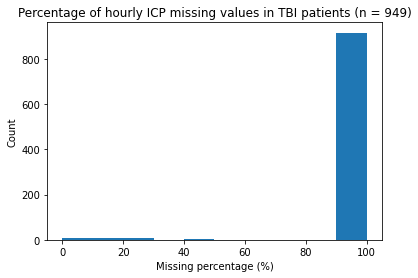

In [22]:
ICP_missing = []
import numpy as np
import matplotlib.pyplot as plt 

for i in range(len(batch_hourly)):
    percent_missing = batch_hourly[i].isnull().sum() * 100 / len(batch_hourly[i])
    ICP_missing.append(percent_missing.values)

plt.hist(np.concatenate(ICP_missing))
plt.title('Percentage of hourly ICP missing values in TBI patients (n = 949)')
plt.xlabel('Missing percentage (%)')
plt.ylabel('Count')
plt.savefig('ICP_missing_values.png')


In [23]:
48//24

2